EfficientDet D0 모델과 D2모델 사용해서 가구 데이터 inference 수행

모델은 pretrained 된 모델을 tensorflow-hub를 통해 다운받아 사용

코드가 연구실 서버에서 실행시킨 것이기 때문에 수정이 필요할 경우 데이터 위치 확인 필요

In [1]:
import tensorflow as tf
tf.__version__

'2.4.0'

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

TF Hub에서 EfficientDet d0 Inference 모델 다운로드 후 Inference 수행.
- 원하는 모델명은 TF Hub에서 검색해서 hub.lod()로 다운로드 후 tensorflow로 사용 가능할 수 있도록 로딩됨
- EfficientDet Tensorflow Object Detection API로 구현된 모델로 Download
- 로딩된 모델은 바로 원본 이미지로 Object Detection이 가능. 입력 값으로 numpy array, tensor 모두 가능하며 uint8로 구성 필요

In [3]:
#EfficientDetD0 512x512로 학습된 모델 다운
module_handle="https://tfhub.dev/tensorflow/efficientdet/d0/1"
detector_model=hub.load(module_handle)

In [4]:
import cv2
import time
import numpy as np

In [5]:
img_array_np=cv2.imread('/home/plass-heesu/KimHeeSu/munsu/Hanssem/Hanssem_data/수납장/69127.png')
img_array=img_array_np[np.newaxis,...] #모델에서 4차원을 기대하기 때문에 차원 추가
print(img_array_np.shape, img_array.shape)

(550, 550, 3) (1, 550, 550, 3)


In [6]:
start_time=time.time()
#image를 detector_model에 인자로 입력하여 inference 수행
result=detector_model(img_array)
print('elapsed time : ', time.time()-start_time)

elapsed time :  3.432229518890381


In [7]:
#np로 넣으니까 처음 실행시 시간이 조금 걸리는건가? 해서 tensor로 바꿔서 입력
img_tensor=tf.convert_to_tensor(img_array_np, dtype=tf.uint8)[tf.newaxis,...]
start_time=time.time()
#image를 detector_model에 인자로 입력하여 inference 수행
result=detector_model(img_tensor)
print('elapsed time : ', time.time()-start_time)

elapsed time :  0.12673330307006836


In [8]:
#image를 numpy가 아니라 tensor로 로딩
def load_img(path):
    img=tf.io.read_file(path)
    #png파일일 경우 decode_png()호출
    img=tf.image.decode_jpeg(img, channels=3)
    print(img.shape, type(img))
    return img

In [9]:
import time

#image를 tensor형태로 로딩
img=load_img('/home/plass-heesu/KimHeeSu/munsu/Hanssem/Hanssem_data/수납장/69127.png')
#3차원 image tensor를 4차원 tensor로 변환
#Efficientdet d0의 경우에는 입력 image를 uint8로 적용 필요
converted_img=tf.image.convert_image_dtype(img, tf.uint8)[tf.newaxis, ...]

start_time=time.time()
#image를 detector_model에 인자로 입력하여 inference 수행
result=detector_model(converted_img)
print('elapsed time : ', time.time()-start_time)

(550, 550, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>
elapsed time :  0.1291944980621338


inference 수행 반환값 확인
- inference 결과는 dictionary 형태로 반환되며, 개별 key값은 Object Detection 모델에 따라 달라질 수 있음. 개별 value는 tensor로 되어 있음.
- inference 반환된 bbox 좌표는 이미지 사이즈 대비 스케일링 된 0~1 사이 값이며 ymin, xmin, ymax, xmax 형태로 반환되므로 반드시 주의 필요

In [10]:
#inference 결과 출력. dictionary 형태의 출력 결과. dict 내부의 key는 model 별로 서로 다름
#출력하여 key값 확인 필요
print(result)

{'raw_detection_scores': <tf.Tensor: shape=(1, 49104, 90), dtype=float32, numpy=
array([[[8.4464729e-02, 1.9974262e-02, 3.1333983e-02, ...,
         3.6311716e-02, 1.3449401e-02, 2.7687103e-02],
        [2.8070509e-03, 7.6663494e-04, 9.1814995e-04, ...,
         1.5496612e-03, 1.8290877e-03, 1.2264252e-03],
        [2.0483136e-04, 5.3280863e-05, 2.8146154e-05, ...,
         7.6534794e-05, 5.4514408e-04, 9.3244205e-05],
        ...,
        [3.8806200e-03, 1.2308061e-03, 1.5587807e-03, ...,
         1.2429953e-03, 1.1965632e-03, 1.4903247e-03],
        [5.0033033e-03, 1.4324486e-03, 1.6117394e-03, ...,
         1.4207959e-03, 1.1401176e-03, 1.1705756e-03],
        [5.6191683e-03, 1.2253225e-03, 1.4645159e-03, ...,
         1.4045835e-03, 1.0341108e-03, 1.2033880e-03]]], dtype=float32)>, 'detection_multiclass_scores': <tf.Tensor: shape=(1, 100, 90), dtype=float32, numpy=
array([[[1.0263026e-02, 9.3950331e-03, 8.6694658e-03, ...,
         5.9975088e-03, 7.0101023e-04, 2.2348762e-04],
    

In [11]:
print(result.keys())
#detect 결과는 100개를 기본으로 Detect함
#(즉 Detect 된 오브젝트는 무조건 100개. 그래서 tensor(array)는 100개 단위, num_detections는 100)
print(result['detection_boxes'].shape, result['detection_classes'].shape, result['detection_scores'].shape, result['num_detections'])

dict_keys(['raw_detection_scores', 'detection_multiclass_scores', 'detection_boxes', 'detection_scores', 'raw_detection_boxes', 'detection_anchor_indices', 'num_detections', 'detection_classes'])
(1, 100, 4) (1, 100) (1, 100) tf.Tensor([100.], shape=(1,), dtype=float32)


num_detections : 찾은 물체 갯수
detection_scores : 100개에 대한 confidence score, 객체가 bbox에 있는지 없는지에 대한 정확도

In [12]:
#detect된 object들은 detection score가 높은 순으로 array값을 채움
print('####detection_classes #####')
print(result['detection_classes'])
print('#### detection_scores #####')
print(result['detection_scores'])
#디텍션 스코어가 가장 높은 값부터 정렬됨
#0.8에 해당 되는 클래스는 62번

####detection_classes #####
tf.Tensor(
[[62. 72. 64. 84. 65. 44. 63. 44. 63. 62. 67. 75. 64. 82. 63. 65. 84. 67.
  44. 65. 63. 62. 44. 84. 75. 64. 86. 15. 82. 86. 62. 88. 64. 73. 86. 63.
  61. 51. 47. 77. 78. 65. 63. 82. 86. 28. 62. 64. 47. 86.  1.  1. 86. 67.
   1. 18. 84. 15. 77. 17. 62. 62. 67. 88. 79. 64. 62. 63. 63. 18. 86. 65.
  76.  1. 67. 63. 63. 75. 46. 44.  2. 64. 67. 59. 63. 79. 79. 65. 86. 63.
  47. 62. 18. 44. 19. 65. 72. 63.  1. 48.]], shape=(1, 100), dtype=float32)
#### detection_scores #####
tf.Tensor(
[[0.82486874 0.5399589  0.4493078  0.44768372 0.4351127  0.41128135
  0.36058733 0.32029    0.27900863 0.26307896 0.26250428 0.2560378
  0.24398959 0.21875176 0.18940586 0.1828843  0.18190718 0.17746457
  0.1764844  0.1622569  0.15918863 0.15225855 0.15112317 0.14956275
  0.14802724 0.14742064 0.14467877 0.13756001 0.13703904 0.13663149
  0.13230512 0.12061489 0.12028202 0.12025431 0.11840269 0.11839062
  0.11762851 0.11751476 0.11186981 0.10754231 0.10717762 0.10330543
 

In [13]:
#bounding box 좌표는 ymin, xmin, ymax, xmax 순서로 반환됨. y가 먼저, x가 나중에 나오므로 반드시 주의해야 함
#좌표 값은 원본 이미지의 width, height로 0-1 사이값으로 정규화됨
#나중에 해당 값을 원본 이미지 좌표값으로 바꾸기 위해서는 원본 이미지의 size를 곱하면 됨
print('#### detection_boxes #####')
print(result['detection_boxes'])

#### detection_boxes #####
tf.Tensor(
[[[0.424587   0.37457597 0.95547795 0.72404575]
  [0.06189576 0.2568737  0.33959746 0.67407036]
  [0.48386964 0.80313766 0.8310826  0.9262309 ]
  [0.32744873 0.43326873 0.38077003 0.54500693]
  [0.46812755 0.         0.8475985  0.14279762]
  [0.25984192 0.6748598  0.34628046 0.7101318 ]
  [0.46249333 0.00101905 0.9756063  0.16691294]
  [0.27236694 0.6387494  0.3433125  0.66360635]
  [0.7115773  0.00125761 0.99368954 0.17990898]
  [0.11355498 0.1590305  0.9235549  0.73287076]
  [0.07798818 0.13356188 0.9359708  0.7689657 ]
  [0.32744873 0.43326873 0.38077003 0.54500693]
  [0.48836464 0.8204717  0.705821   0.91596335]
  [0.06584251 0.26555765 0.34225267 0.6829518 ]
  [0.6488621  0.0078909  0.9975499  0.3320229 ]
  [0.6281865  0.00260471 0.9884123  0.16654293]
  [0.3399722  0.53877574 0.37111896 0.6073522 ]
  [0.4917726  0.34007663 0.96465224 0.70514053]
  [0.27792168 0.6317031  0.34153926 0.6538666 ]
  [0.42582747 0.00417131 0.9777852  0.25258088]
  

inference 결과를 이미지로 시각화

In [14]:
#result 내의 value들을 모두 numpy로 변환
result={key:value.numpy() for key, value in result.items()}

In [15]:
#1부터 91까지의 COCO Class id 매핑
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [16]:
def get_detector(module_handle="https://tfhub.dev/tensorflow/efficientdet/d0/1"):
    detector=hub.load(module_handle)
    return detector

detector_model=get_detector()

In [18]:
import os
from glob import glob

path = os.listdir('/home/plass-heesu/KimHeeSu/munsu/Hanssem/Hanssem_data/수납장')
image_path=glob('/home/plass-heesu/KimHeeSu/munsu/Hanssem/Hanssem_data/수납장/*.png')
print(image_path[1])
print(type(image_path[0]))

/home/plass-heesu/KimHeeSu/munsu/Hanssem/Hanssem_data/수납장/470145.png
<class 'str'>


/home/plass-heesu/KimHeeSu/munsu/Hanssem/Hanssem_data/수납장/516981.png


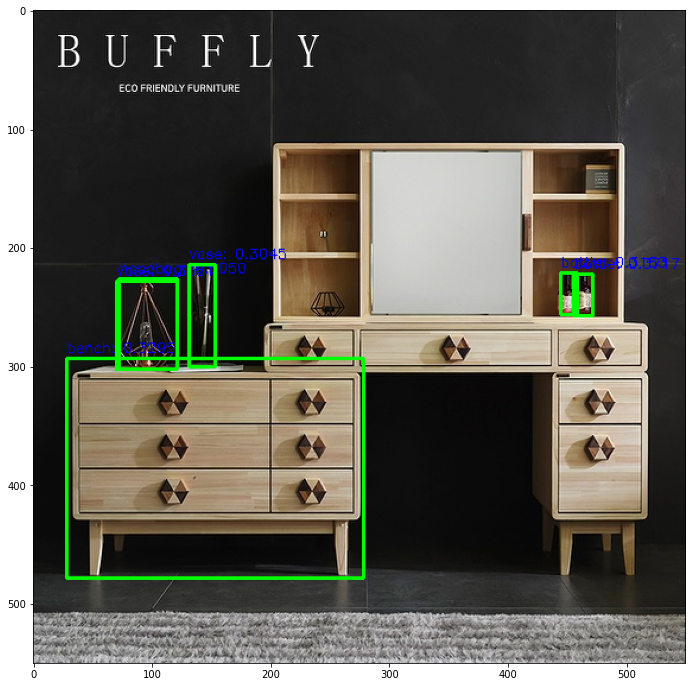

In [19]:
import cv2
from glob import glob

image_path=glob('/home/plass-heesu/KimHeeSu/munsu/Hanssem/Hanssem_data/수납장/*.png')
img_array=cv2.cvtColor(cv2.imread(image_path[0]), cv2.COLOR_BGR2RGB)

#scaling된 이미지 기반으로 bounding box위치가 예측 되므로
#이를 다시 원복하기 위해 원본 이미지 shape 정보 필요
#bbox가 0에서 1사이 값으로 정규화되서 나오기 때문에 다시 곱해야 원본에서의 위치 정보를 알 수 있다
height=img_array.shape[0]
width=img_array.shape[1]
#cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로
#그림 표현을 위한 별도의 이미지 배열 생성
draw_img=img_array.copy()

#bounding bos의 테두리와 caption글자색 지정
green_color=(0, 255, 0)
red_color=(0,0,255)

#cv2로 만들어진 numpy image array를 tensor로 변환
img_tensor=tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
#img_tensor=tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxiz, ...]

#pretrained 모델을 다운로드 한 뒤 inference 수행
result=detector_model(img_tensor)
#reuslt 내부의 value를 numpy로 변환
result={key:value.numpy() for key, value in result.items()}

SCORE_THRESHOLD=0.3
OBJECT_DEFAULT_COUNT=100

#detected 된 object들을 iteration하면서 정보 추출
#detect된 object의 갯수는 100개
for i in range(min(result['detection_scores'][0].shape[0], OBJECT_DEFAULT_COUNT)):
    #detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop중단.
    score=result['detection_scores'][0,i]
    if score<SCORE_THRESHOLD:
        break
    box=result['detection_boxes'][0,i]

    xmin = box[1]*width
    ymin = box[0]*height
    xmax = box[3]*width
    ymax = box[2]*height

    class_id=result['detection_classes'][0,i]
    caption="{}: {:.4f}".format(labels_to_names[class_id],score)
    #cv2.rectangel()은 인자로 들어온 draw_img에 사각형을 그리는 함수. 위치 인자는 반드시 정수형
    cv2.rectangle(draw_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(xmin), int(ymin-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

plt.figure(figsize=(12,12))
plt.imshow(draw_img)
print(image_path[0])

In [20]:
import time

def get_detected_img(model, img_array, score_threshold, object_show_count=100, is_print=True):   
  # scaling된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
  height = img_array.shape[0]
  width = img_array.shape[1]
  # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
  draw_img = img_array.copy()

  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  # cv2로 만들어진 numpy image array를 tensor로 변환
  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
  #img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

  # efficientdet모델로 inference 수행. 
  start_time = time.time()
  # inference 결과로 내부 원소가 Tensor이 Dict 반환 
  result = model(img_tensor)
  # result 내부의 value를 numpy 로 변환. 
  result = {key:value.numpy() for key,value in result.items()}

  # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
  for i in range(min(result['detection_scores'][0].shape[0], object_show_count)):
    # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
    score = result['detection_scores'][0, i]
    if score < score_threshold:
      break
    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    box = result['detection_boxes'][0, i]

    ''' **** 주의 ******
    box는 ymin, xmin, ymax, xmax 순서로 되어 있음. '''
    left = box[1] * width
    top = box[0] * height
    right = box[3] * width
    bottom = box[2] * height

    # class id 추출하고 class 명으로 매핑
    class_id = result['detection_classes'][0, i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    print(caption)
    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

  if is_print:
    print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

  return draw_img

handbag: 0.5050
Detection 수행시간: 0.13 초


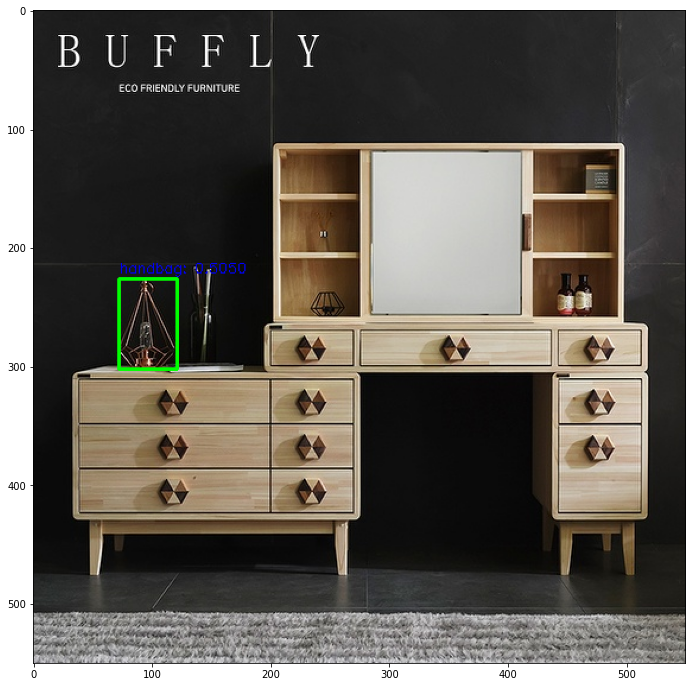

In [21]:
img_array = cv2.cvtColor(cv2.imread(image_path[0]), cv2.COLOR_BGR2RGB)
draw_img = get_detected_img(detector_model, img_array, score_threshold=0.4, object_show_count=100, is_print=True)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)
#score_threshold 값을 0.4로 했더니 박스 하나만 출력

/home/plass-heesu/KimHeeSu/munsu/Hanssem/Hanssem_data/수납장/470145.png
chair: 0.6768
potted plant: 0.6221
potted plant: 0.5493
potted plant: 0.5071
vase: 0.4100
Detection 수행시간: 0.13 초


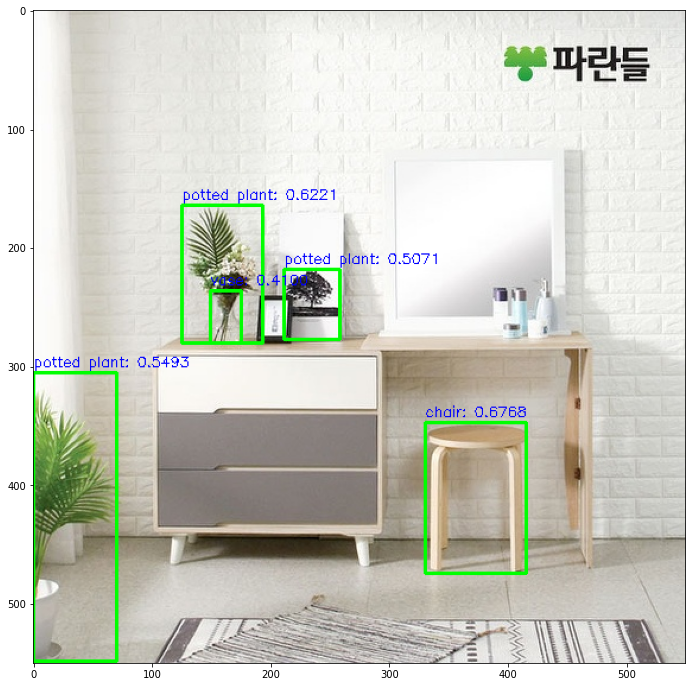

In [22]:
print(image_path[1])
img_array=cv2.cvtColor(cv2.imread(image_path[1]), cv2.COLOR_BGR2RGB)
draw_img=get_detected_img(detector_model, img_array, score_threshold=0.4, object_show_count=100, is_print=True)

plt.figure(figsize=(12,12))
plt.imshow(draw_img)

EfficientDet D2모델로 inference 수행

In [23]:
detector_model_d2=get_detector('https://tfhub.dev/tensorflow/efficientdet/d2/1')

/home/plass-heesu/KimHeeSu/munsu/Hanssem/Hanssem_data/수납장/516981.png
bottle: 0.6224
bottle: 0.6098
Detection 수행시간: 0.33 초


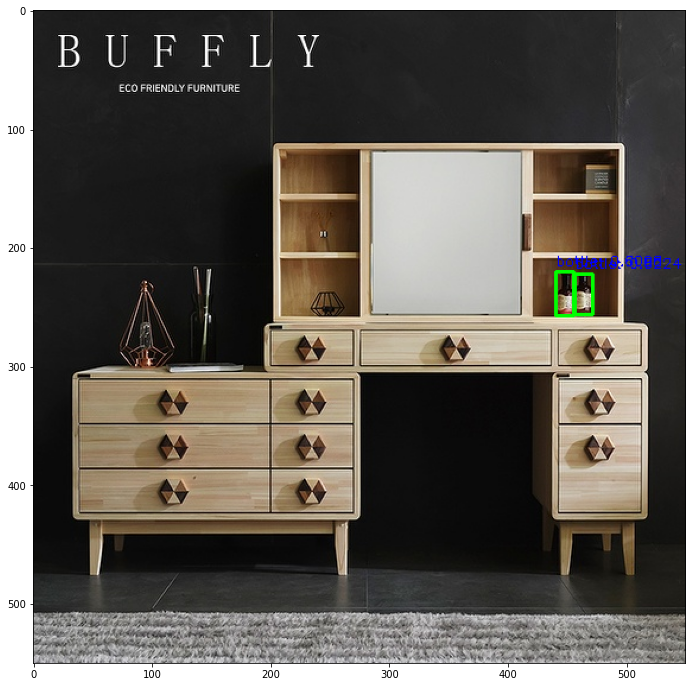

In [26]:
print(image_path[0])
img_array=cv2.cvtColor(cv2.imread(image_path[0]), cv2.COLOR_BGR2RGB)
draw_img=get_detected_img(detector_model_d2, img_array, score_threshold=0.4, object_show_count=100, is_print=True)

plt.figure(figsize=(12,12))
plt.imshow(draw_img)

/home/plass-heesu/KimHeeSu/munsu/Hanssem/Hanssem_data/수납장/470145.png
chair: 0.7840
vase: 0.7416
potted plant: 0.6158
potted plant: 0.5893
potted plant: 0.5117
Detection 수행시간: 0.37 초


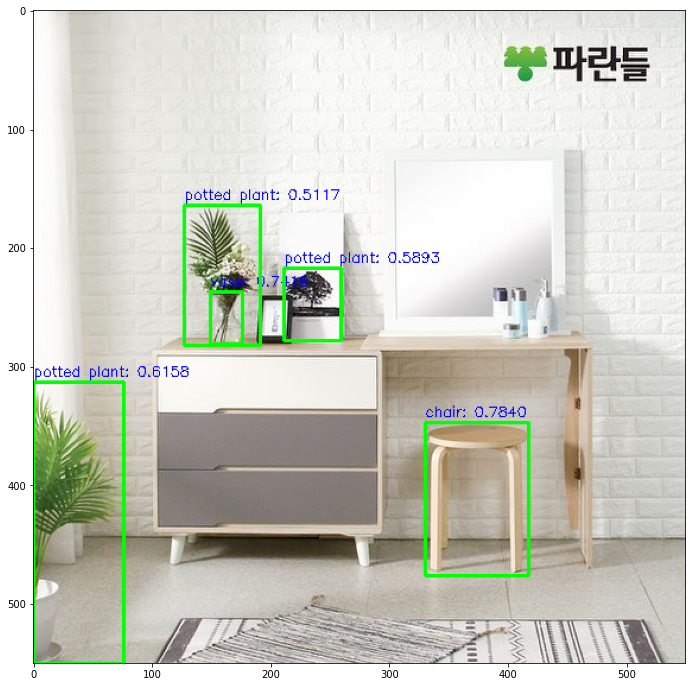

In [28]:
print(image_path[1])
img_array=cv2.cvtColor(cv2.imread(image_path[1]), cv2.COLOR_BGR2RGB)
draw_img=get_detected_img(detector_model_d2, img_array, score_threshold=0.4, object_show_count=100, is_print=True)

plt.figure(figsize=(12,12))
plt.imshow(draw_img)